In [2]:
# Imports
import json
import os
import cv2
import numpy as np
import requests
from tqdm import tqdm
import random
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, Flatten, Dense, Dropout)
# File paths (thses are the paths for the video and json files)
WLASL_JSON_PATH = 'risangbaskoro/wlasl-processed/versions/5/WLASL_v0.3.json'
NSLT_JSON_PATH = 'risangbaskoro/wlasl-processed/versions/5/nslt_100.json'
MISSING_IDS_PATH = 'risangbaskoro/wlasl-processed/versions/5/missing.txt'
VIDEOS_FOLDER = 'risangbaskoro/wlasl-processed/versions/5/videos'
CLASS_LIST_PATH = 'risangbaskoro/wlasl-processed/versions/5/wlasl_class_list.txt'
OUTPUT_DIRECTORY = '.'

# Create output directories for each of training,val and test
TRAIN_DIR = os.path.join(OUTPUT_DIRECTORY, "train")
VAL_DIR = os.path.join(OUTPUT_DIRECTORY, "val")
TEST_DIR = os.path.join(OUTPUT_DIRECTORY, "test")
CROPPED_VIDEOS_DIR = os.path.join(OUTPUT_DIRECTORY, "cropped_videos")
os.makedirs(TRAIN_DIR, exist_ok=True)
os.makedirs(VAL_DIR, exist_ok=True)
os.makedirs(TEST_DIR, exist_ok=True)
os.makedirs(CROPPED_VIDEOS_DIR, exist_ok=True)

# Load the json into a python object to make it accessible to the caller
def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

# There are some missing videos in the dataset which are located in missing_list.txt. so, we have to ignore them.
def read_missing_videos(file_path):
    with open(file_path, 'r') as f:
        return {line.strip() for line in f if line.strip()}

def load_class_list(file_path):
    with open(file_path, 'r') as f:
        return [line.strip().split('\t')[1] for line in f]

def download_video(url, video_id):
    video_path = os.path.join(VIDEOS_FOLDER, f"{video_id}.mp4")
    if os.path.exists(video_path):
        return video_path
    try:
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with open(video_path, 'wb') as f:
                for chunk in tqdm(response.iter_content(chunk_size=1024), desc=f"Downloading {video_id}"):
                    f.write(chunk)
            return video_path
        else:
            print(f"[ERROR] Failed to download video {video_id}: HTTP {response.status_code}")
    except Exception as e:
        print(f"[ERROR] Error downloading video {video_id}: {e}")
    return None

# Save the video of each one that corresponds to a set (training, val or test) to the directory of each set  
def save_video(frames_array, output_path, fps=25):
    if len(frames_array.shape) == 3:
        frames_array = np.expand_dims(frames_array, axis=-1)

    num_frames, height, width, channels = frames_array.shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames_array:
        frame_bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        out.write(frame_bgr)

    out.release()

# crop the video based on the bound box provided in the json files in the dataset
def crop_video(video_path, bbox, output_path):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"[ERROR] Failed to open video {video_path}")
        return None

    fps = cap.get(cv2.CAP_PROP_FPS)
    if fps == 0:
        fps = 25

    x_min, y_min, x_max, y_max = bbox
    width, height = x_max - x_min, y_max - y_min

    if width <= 0 or height <= 0:
        print(f"[ERROR] Invalid bounding box dimensions: {bbox}")
        cap.release()
        return None

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame is None or frame.shape[0] == 0 or frame.shape[1] == 0:
            print(f"[ERROR] Invalid frame encountered in video {video_path}")
            break
        try:
            cropped_frame = frame[y_min:y_max, x_min:x_max]
            if cropped_frame.shape[0] == 0 or cropped_frame.shape[1] == 0:
                print(f"[ERROR] Cropped frame has invalid dimensions: {cropped_frame.shape}")
                break
            if cropped_frame.shape[2] != 3:
                print(f"[ERROR] Cropped frame does not have 3 channels: {cropped_frame.shape}")
                break
            out.write(cropped_frame)
        except Exception as e:
            print(f"[ERROR] Exception while cropping frame: {e}")
            break

    cap.release()
    out.release()
    return output_path

# pre-process the frames and split the videos between test, val and test
def process_video_frames(video_path, video_id, split, target_frames=16, target_size=(128, 128), crop_prob=0.5, crop_fraction=0.8):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frames.append(gray_frame)
    cap.release()

    if not frames:
        print(f"[WARNING] No frames extracted for Video ID: {video_id}. Skipping this video.")
        return None

    if split == 'train':
        if random.random() < crop_prob:
            cropped_frames = []
            for frame in frames:
                height, width = frame.shape
                crop_h, crop_w = int(height * crop_fraction), int(width * crop_fraction)
                start_h, start_w = (height - crop_h) // 2, (width - crop_w) // 2
                cropped_frame = frame[start_h:start_h + crop_h, start_w:start_w + crop_w]
                cropped_frames.append(cropped_frame)
            frames = cropped_frames

    num_frames = len(frames)
    if num_frames < target_frames:
        blank_frame = np.zeros_like(frames[0])
        frames += [blank_frame] * (target_frames - num_frames)
    elif num_frames > target_frames:
        indices = np.linspace(0, num_frames - 1, target_frames, dtype=int)
        frames = [frames[i] for i in indices]

    standardized_frames = []
    for frame in frames:
        resized_frame = cv2.resize(frame, target_size)
        normalized_frame = resized_frame / 255.0
        normalized_frame = np.expand_dims(normalized_frame, axis=-1)
        standardized_frames.append(normalized_frame)
    frames_array = np.array(standardized_frames)

    if split == 'train' and random.random() < 0.5:
        frames_array = np.array([cv2.flip(f, 1) for f in frames_array])

    return frames_array

# get a list of the unique words (25 in this case) chosen from WLASL-100
def get_unique_words_and_encode(nslt_data, class_list):
    unique_glosses = set()
    for data in nslt_data.values():
        gloss_number = data['action'][0]
        if 0 <= gloss_number < len(class_list):
            gloss = class_list[gloss_number]
        else:
            gloss = f"unknown_gloss_{gloss_number}"
        unique_glosses.add(gloss)
    unique_glosses = sorted(list(unique_glosses))
    selected_glosses = unique_glosses[:25]

    gloss_to_index = {gloss: idx for idx, gloss in enumerate(selected_glosses)}
    y = {}
    for video_id, data in nslt_data.items():
        gloss_number = data['action'][0]
        if 0 <= gloss_number < len(class_list):
            gloss = class_list[gloss_number]
        else:
            gloss = f"unknown_gloss_{gloss_number}"
        if gloss in gloss_to_index:
            label_index = gloss_to_index[gloss]
            y[video_id] = to_categorical(label_index, num_classes=len(selected_glosses))
    return y, selected_glosses

nslt_data_1 = load_json(NSLT_JSON_PATH)
class_list_1 = load_class_list(CLASS_LIST_PATH)

# Get unique glosses and one-hot encoded labels for selected 25 glosses
y, unique_glosses_25 = get_unique_words_and_encode(nslt_data_1, class_list_1)
y_with_gloss_names = {}
for video_id, one_hot_label in y.items():
    gloss_number = nslt_data_1[video_id]['action'][0]
    if 0 <= gloss_number < len(class_list_1):
        gloss_name = class_list_1[gloss_number]
    else:
        gloss_name = f"unknown_gloss_{gloss_number}"
    if gloss_name in unique_glosses_25:
        y_with_gloss_names[gloss_name] = one_hot_label

output_file_path = os.path.join(OUTPUT_DIRECTORY, 'y_with_gloss_names.txt')
with open(output_file_path, 'w') as f:
    for gloss_name, one_hot_label in y_with_gloss_names.items():
        f.write(f"{gloss_name}: {one_hot_label.tolist()}\n")

def main():
    global train_data, val_data, test_data
    nslt_data = load_json(NSLT_JSON_PATH)
    wlasl_data = load_json(WLASL_JSON_PATH)
    missing_ids = read_missing_videos(MISSING_IDS_PATH)
    class_list = load_class_list(CLASS_LIST_PATH)

    # We already have y_with_gloss_names and unique_glosses_25 from above steps

    train_data = {}
    val_data = {}
    test_data = {}

    video_count = 0
    missing_count = 0
    # preparing the variable for the processing part
    wlasl_lookup = {instance['video_id']: {'gloss': entry['gloss'], 'bbox': instance['bbox'], 'split': instance['split'], 'url': instance['url']}
                    for entry in wlasl_data for instance in entry['instances']}

    for video_id, data in nslt_data.items():
        gloss_number = data['action'][0]
        if 0 <= gloss_number < len(class_list):
            gloss = class_list[gloss_number]
        else:
            gloss = f"unknown_gloss_{gloss_number}"

        # Only process videos if the gloss is in the selected 25 glosses
        if gloss not in unique_glosses_25:
            continue

        if video_id in missing_ids:
            missing_count += 1
            print(f"[INFO] Skipping missing video {video_id}")
            continue

        if video_id not in wlasl_lookup:
            print(f"[ERROR] No metadata found for video ID {video_id}")
            continue

        video_info = wlasl_lookup[video_id]
        bbox = video_info['bbox']
        split = video_info['split']
        url = video_info['url']

        video_count += 1
        print(f"\n[INFO] Processing video {video_count}: Video ID {video_id} (Gloss: {gloss}, Split: {split})")

        video_path = os.path.join(VIDEOS_FOLDER, f"{video_id}.mp4")

        if not os.path.exists(video_path):
            print(f"[INFO] Downloading video {video_id}...")
            video_path = download_video(url, video_id)
            if not video_path:
                continue

        cropped_video_path = os.path.join(CROPPED_VIDEOS_DIR, f"{video_id}_cropped.mp4")
        cropped_video = crop_video(video_path, bbox, cropped_video_path)
        if not cropped_video:
            continue

        frames_array = process_video_frames(cropped_video, video_id, split)
        if frames_array is None:
            continue

        if split == 'train':
            train_data[video_id] = {'frames': frames_array, 'gloss': gloss}
        elif split == 'val':
            val_data[video_id] = {'frames': frames_array, 'gloss': gloss}
        else:
            test_data[video_id] = {'frames': frames_array, 'gloss': gloss}

        output_folder = TRAIN_DIR if split == 'train' else VAL_DIR if split == 'val' else TEST_DIR
        os.makedirs(output_folder, exist_ok=True)
        output_path = os.path.join(output_folder, f"{video_id}.mp4")
        save_video(frames_array, output_path)

    print("\nProcessing complete.")
    print(f"Total videos processed: {video_count}")
    print(f"Train set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")
    print(f"Missing Videos: {missing_count}")

if __name__ == '__main__':
    main()

# adjust the way the data is formed to have the key as the gloss and its value is its frames
def transform_data(data):
    transformed = {}
    count = 1
    for video_id, item in data.items():
        gloss = item['gloss']
        frames = item['frames']
        print(video_id, count)
        rounded_frames = frames.round(3).tolist()
        if gloss in transformed:
            transformed[gloss].append(rounded_frames)
        else:
            transformed[gloss] = [rounded_frames]
        count += 1
    return transformed

train_data_transformed = transform_data(train_data)
val_data_transformed = transform_data(val_data)
test_data_transformed = transform_data(test_data)

[INFO] Skipping missing video 05237
[INFO] Skipping missing video 10899

[INFO] Processing video 1: Video ID 10898 (Gloss: city, Split: val)

[INFO] Processing video 2: Video ID 10893 (Gloss: city, Split: train)

[INFO] Processing video 3: Video ID 10892 (Gloss: city, Split: train)
[INFO] Skipping missing video 10896

[INFO] Processing video 4: Video ID 10895 (Gloss: city, Split: train)

[INFO] Processing video 5: Video ID 10894 (Gloss: city, Split: train)

[INFO] Processing video 6: Video ID 65278 (Gloss: but, Split: train)

[INFO] Processing video 7: Video ID 06365 (Gloss: birthday, Split: train)

[INFO] Processing video 8: Video ID 06335 (Gloss: bird, Split: test)

[INFO] Processing video 9: Video ID 06334 (Gloss: bird, Split: train)

[INFO] Processing video 10: Video ID 06337 (Gloss: bird, Split: train)
[INFO] Skipping missing video 06336

[INFO] Processing video 11: Video ID 06331 (Gloss: bird, Split: train)

[INFO] Processing video 12: Video ID 06330 (Gloss: bird, Split: val)

[I

In [2]:
print(len(train_data))
print(len(val_data))
print(len(test_data))

NameError: name 'train_data' is not defined

In [5]:
# build the dataset and ensure valid dimensions
def build_dataset(data_transformed, y_with_gloss_names):
    X_list = []
    Y_list = []

    for gloss, videos_list in data_transformed.items():
        if gloss not in y_with_gloss_names:
            continue
        label = y_with_gloss_names[gloss]
        for v in videos_list:
            arr = np.array(v, dtype=np.float32)
            if arr.ndim == 3:
                arr = np.expand_dims(arr, axis=-1)
            if arr.shape != (16, 128, 128, 1):
                print(f"[WARNING] Found a shape mismatch: {arr.shape}. Skipping this video.")
                continue
            X_list.append(arr)
            Y_list.append(label)

    if len(X_list) == 0:
        raise ValueError("No valid data found to build the dataset.")

    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.float32)
    return X, Y

# Spli the data
X_train, y_train = build_dataset(train_data_transformed, y_with_gloss_names)
X_val, y_val = build_dataset(val_data_transformed, y_with_gloss_names)
X_test, y_test = build_dataset(test_data_transformed, y_with_gloss_names)

# insure
print("[INFO] Dataset shapes:")
print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val:", X_val.shape, X_val.dtype)
print("y_val:", y_val.shape, y_val.dtype)
print("X_test:", X_test.shape, X_test.dtype)
print("y_test:", y_test.shape, y_test.dtype)

[INFO] Dataset shapes:
X_train: (177, 16, 128, 128, 1) float32
y_train: (177, 25) float32
X_val: (35, 16, 128, 128, 1) float32
y_val: (35, 25) float32
X_test: (25, 16, 128, 128, 1) float32
y_test: (25, 25) float32


In [ ]:
print(len(train_data))

In [29]:
NUM_UNIQUE_WORDS = len(unique_glosses_25)  # Should be 25 now
# As designed 16 frames, (128,128) + Gray scale --> 1 channel
INPUT_SHAPE = (16, 128, 128, 1)

# 3D-CNN
def ThreeDCNN(input_shape, num_unique_words):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_unique_words, activation='softmax'))
    return model

model = ThreeDCNN(INPUT_SHAPE, NUM_UNIQUE_WORDS)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_8 (Conv3D)               │ (None, 14, 126, 126,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_8 (MaxPooling3D)  │ (None, 7, 63, 63, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_9 (Conv3D)               │ (None, 5, 61, 61, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_9 (MaxPooling3D)  │ (None, 2, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,108,057 (225.48 MB)

 Trainable params: 59,108,057 (225.48 MB)

 Non-trainable params: 0 (0.00 B)

Evaluate the model

In [30]:
from tensorflow.keras.callbacks import Callback

class TestEvalCallback(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_losses = []
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(*self.test_data, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_acc)
        # Optionally print or log them
        print(f"Epoch {epoch+1}: Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


# Now include the callback when you train:
test_callback = TestEvalCallback((X_test, y_test))
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[test_callback]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.0197 - loss: 4.8942Epoch 1: Test loss: 3.2191, Test accuracy: 0.0400
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 454ms/step - accuracy: 0.0202 - loss: 4.8534 - val_accuracy: 0.0000e+00 - val_loss: 3.2139
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.0738 - loss: 3.2051Epoch 2: Test loss: 3.2126, Test accuracy: 0.0400
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.0745 - loss: 3.2052 - val_accuracy: 0.0286 - val_loss: 3.2077
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.0757 - loss: 3.2088Epoch 3: Test loss: 3.2110, Test accuracy: 0.1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 435ms/step - accuracy: 0.0746 - loss: 3.2090 - val_accuracy: 0.0571 - val_loss: 3.2102
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.0720 - loss: 3.1909Epoch 4: Test loss: 3.2248, Test accuracy: 0.0400
23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 431ms/step - accuracy: 0.0725 - loss: 3.1905 - val_accuracy: 0.0571 - v

In [9]:
# Train the model
#history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=8, dropout=0.5)

Plot the accurcies and the losses

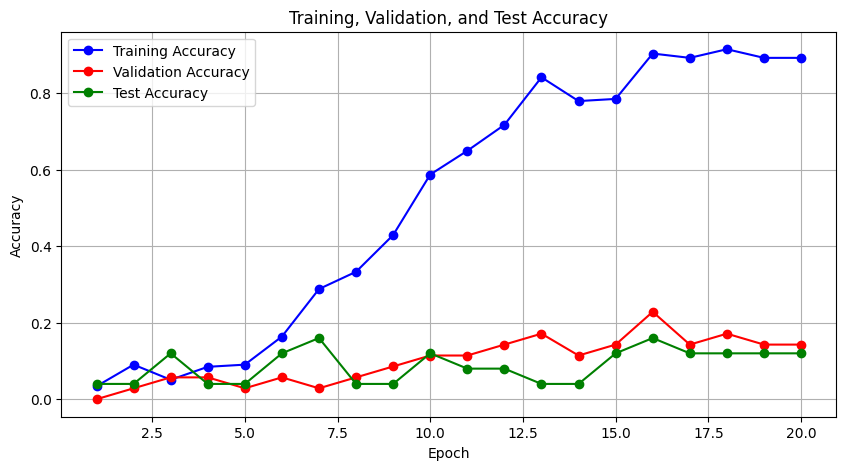

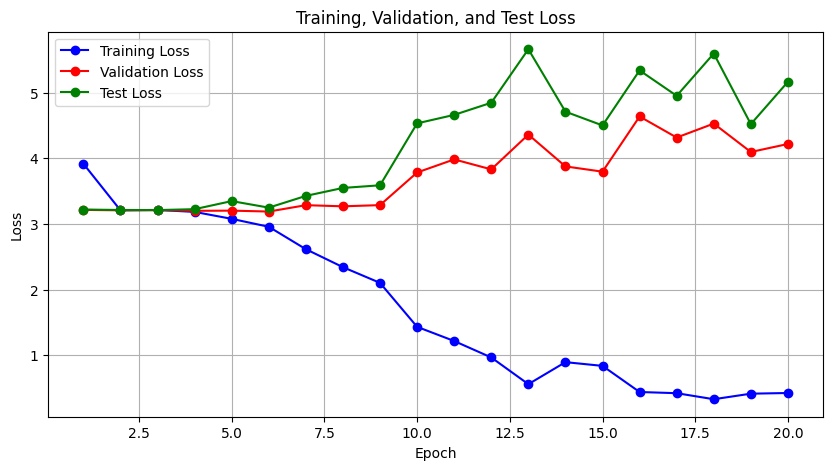

In [31]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Test metrics from the callback
test_acc_list = test_callback.test_accuracies
test_loss_list = test_callback.test_losses

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.plot(epochs, test_acc_list, 'go-', label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.plot(epochs, test_loss_list, 'go-', label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


New model with regularization

In [32]:
from tensorflow.keras.regularizers import l2

NUM_UNIQUE_WORDS = len(unique_glosses_25)  # Should be 25 now
INPUT_SHAPE = (16, 128, 128, 1)

def ThreeDCNN(input_shape, num_unique_words):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=l2(0.001)))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(num_unique_words, activation='softmax'))
    return model

model = ThreeDCNN(INPUT_SHAPE, NUM_UNIQUE_WORDS)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d_10 (Conv3D)              │ (None, 14, 126, 126,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_10 (MaxPooling3D) │ (None, 7, 63, 63, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_11 (Conv3D)              │ (None, 5, 61, 61, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_11 (MaxPooling3D) │ (None, 2, 30, 30, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,108,057 (225.48 MB)

 Trainable params: 59,108,057 (225.48 MB)

 Non-trainable params: 0 (0.00 B)

Plot

In [33]:
from tensorflow.keras.callbacks import Callback

class TestEvalCallback(Callback):
    def __init__(self, test_data):
        super().__init__()
        self.test_data = test_data
        self.test_losses = []
        self.test_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        test_loss, test_acc = self.model.evaluate(*self.test_data, verbose=0)
        self.test_losses.append(test_loss)
        self.test_accuracies.append(test_acc)
        # Optionally print or log them
        print(f"Epoch {epoch+1}: Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


# Now include the callback when you train:
test_callback = TestEvalCallback((X_test, y_test))
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=8,
    callbacks=[test_callback]
)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step - accuracy: 0.0343 - loss: 5.7674Epoch 1: Test loss: 4.3593, Test accuracy: 0.1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 542ms/step - accuracy: 0.0345 - loss: 5.7330 - val_accuracy: 0.0286 - val_loss: 4.3624
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step - accuracy: 0.0423 - loss: 4.3057Epoch 2: Test loss: 4.0823, Test accuracy: 0.1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 524ms/step - accuracy: 0.0429 - loss: 4.3032 - val_accuracy: 0.0286 - val_loss: 4.0828
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.0229 - loss: 4.0236Epoch 3: Test loss: 3.8315, Test accuracy: 0.1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 517ms/step - accuracy: 0.0245 - loss: 4.0212 - val_accuracy: 0.0286 - val_loss: 3.8518
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step - accuracy: 0.0781 - loss: 3.8122Epoch 4: Test loss: 3.7302, Test accuracy: 0.1200
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 516ms/step - accuracy: 0.0774 - loss: 3.8114 - val_accuracy: 0.0286 - val_l

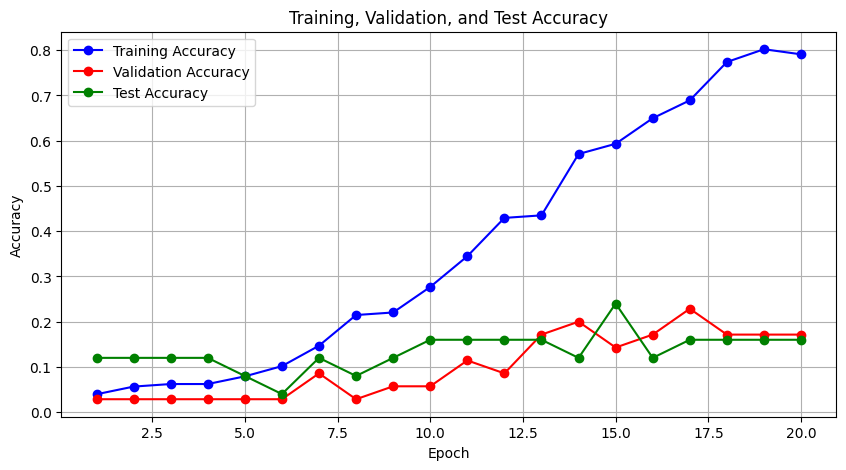

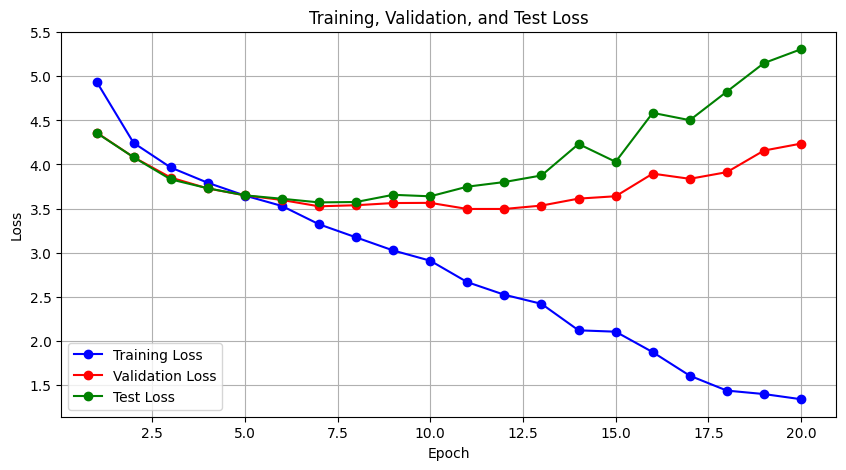

In [34]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Test metrics from the callback
test_acc_list = test_callback.test_accuracies
test_loss_list = test_callback.test_losses

epochs = range(1, len(acc) + 1)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.plot(epochs, test_acc_list, 'go-', label='Test Accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.plot(epochs, test_loss_list, 'go-', label='Test Loss')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
